# 參數設定 (VMD + 使用訊號分解 EEMD)

In [1]:
import os

labels = ['GroupCount']
model_type = 1 # 使用模型
predicteds = [3] # 預測類別 
batch_size = 14  # 批次大小

# labels = ['GroupCount']
# model_type = 1 # 使用模型
# predicteds = [1] # 預測類別 
# batch_size = 14  # 批次大小


# ==== 底下的參數基本上都不要亂動 ====
past_day = 14  # 過去天數，用於訓練資料中的歷史資料長度
future_day = 1
vmd_k = 8 # VMD分解層數
std_num = 1 # 標準差倍數
sigma = 1

train_split_rate = 0.8  # 訓練集佔整體資料集的比例
val_split_rate = 0.1 # 驗證集占整體資料集的比例

is_emd = False # 是否使用 EMD，False 則使用 EEMD 
 
model_dir = 'VMD_DecompEEMD/_Model'

# !pip install EMD-signal
# https://github.com/laszukdawid/PyEMD/tree/master

# 定義類別

In [2]:
import joblib

# 重新載入 Lib，讓檔案可以直接修改使用 
import importlib
import LstmLib 
importlib.reload(LstmLib)   

from LstmLib import * 
lstm = LstmLib()

import sys
print(sys.prefix)

/Users/elliesu/Developer/nckuenv


# 清除舊的訓練資料

In [3]:
x_scaler_file_name, y_scaler_file_name, model_file_name, result_file_name = \
    lstm.reset_data(model_dir, labels, model_type, predicteds, batch_size)

x_scaler_file_name: VMD_DecompEEMD/_Model/GroupCount_mt1_data3_batch14.x_scaler.pkl
y_scaler_file_name: VMD_DecompEEMD/_Model/GroupCount_mt1_data3_batch14.y_scaler.pkl
model_file_name: VMD_DecompEEMD/_Model/GroupCount_mt1_data3_batch14.model.keras
result_file_name: VMD_DecompEEMD/_Model/GroupCount_mt1_data3_batch14.result.json


# 載入數據

In [4]:
df_source = lstm.load_data(predicteds)

print(len(df_source))
df_source.head()

# 載入數據
395


,RequestTime,Predicted,SendBytes,ReceiveBytes,TimeTaken,UrlType1,UrlType2,UrlType3,Method_GET,Method_POST,Method_PUT,Method_DELETE,Method_HEAD,Method_OPTIONS,Method_PATCH,GroupCount
0,2023-04-02,[3],434228991,7104327,1514391,0,12161,11,12143,0,0,0,29,0,0,12172
1,2023-04-03,[3],514748677,8374632,1685290,0,14413,14,14401,1,0,0,25,0,0,14427
2,2023-04-04,[3],495403671,8015605,2356346,0,13724,7,13698,1,0,0,32,0,0,13731
3,2023-04-05,[3],650814803,10389288,1805140,0,17785,40,17817,1,0,0,7,0,0,17825
4,2023-04-06,[3],1515791439,24958451,4215703,0,41506,15,41508,0,0,0,13,0,0,41521


# VMD 訊號分解

In [5]:
data_source = df_source[labels].values
u = lstm.vmd_decomposition(data_source, K = vmd_k)

print(data_source.shape)
print(u.shape)  

(395, 1)
(8, 394)


# 繪製 VMD 訊號分解圖

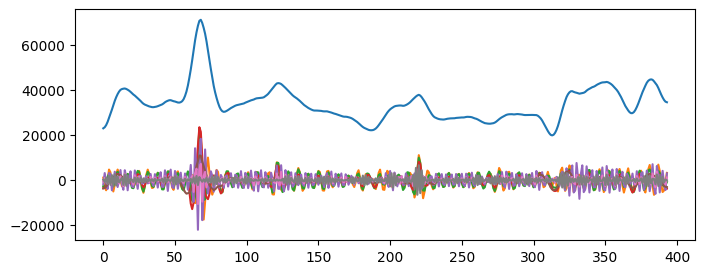

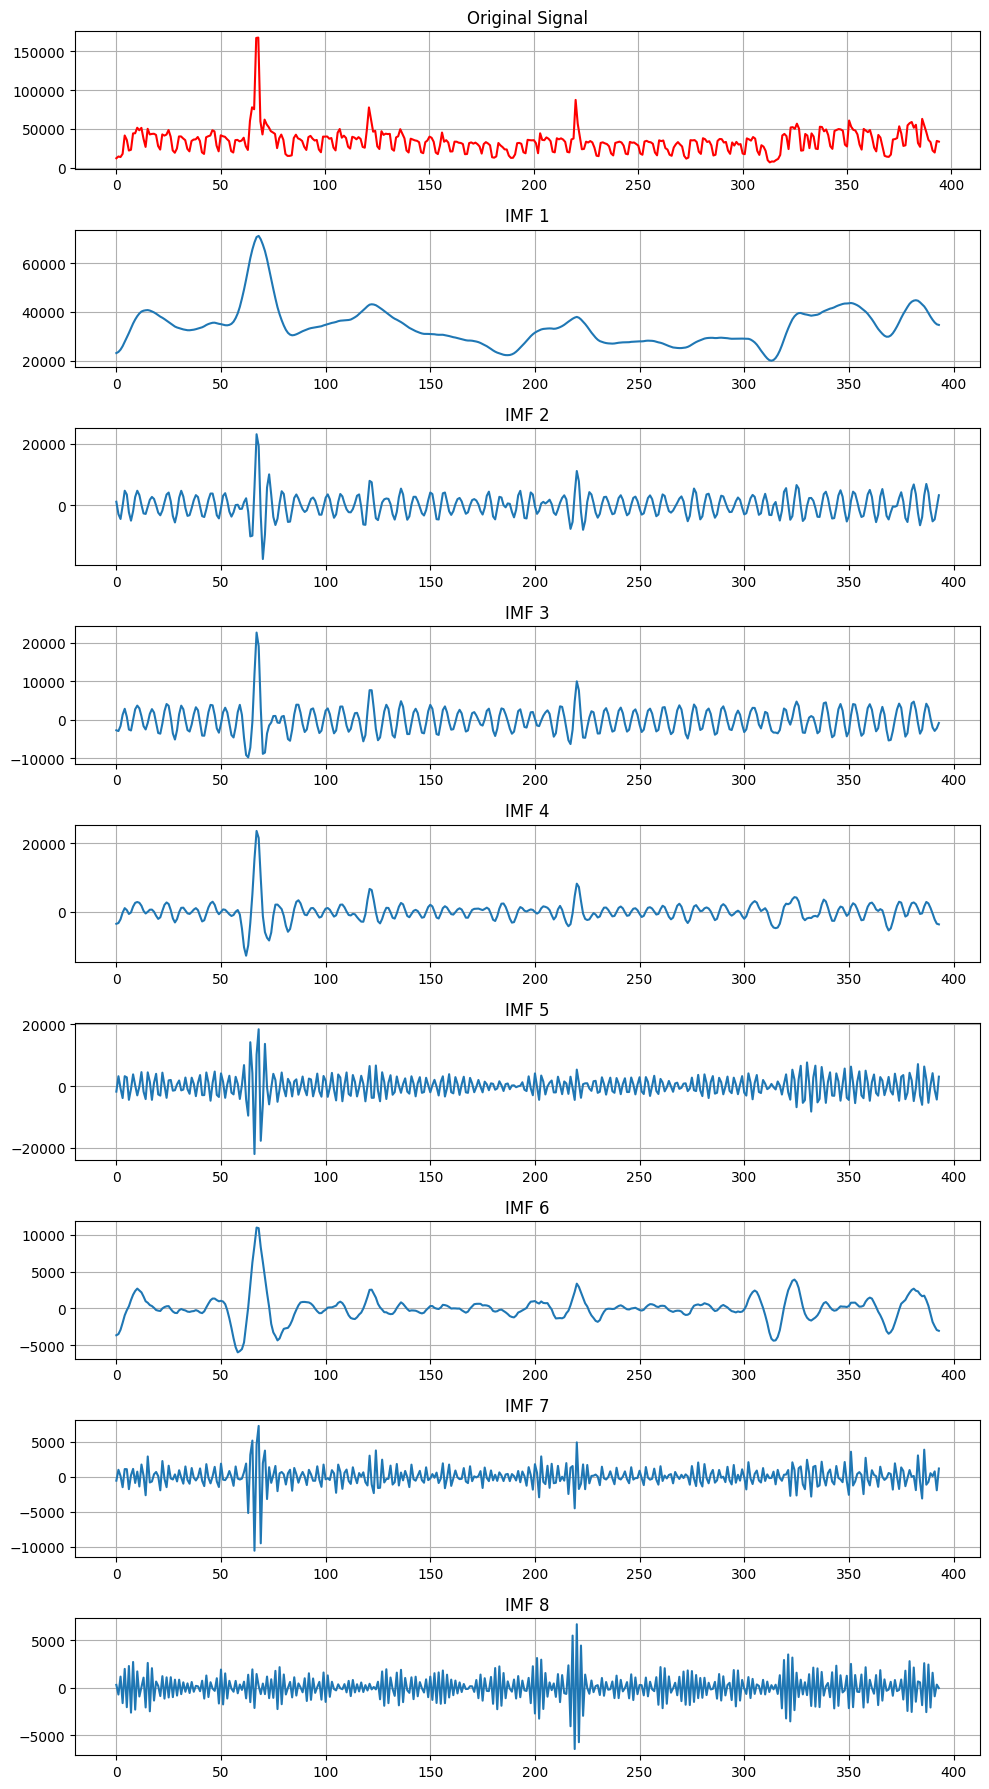

In [6]:
plt.figure(figsize=(8, 3))
plt.plot(u.T)  
plt.show()

lstm.plot_imfs_with_original(data_source, u) 

# VMD 異常資料前處理

IMFs 的數量: 8, 每個 IMF 的長度: 394
將異常部分的值進行平滑處理，imf 1 有 86 個異常點
將異常部分的值進行平滑處理，imf 2 有 98 個異常點
將異常部分的值進行平滑處理，imf 3 有 101 個異常點
將異常部分的值進行平滑處理，imf 4 有 53 個異常點
將異常部分的值進行平滑處理，imf 5 有 94 個異常點
將異常部分的值進行平滑處理，imf 6 有 75 個異常點
將異常部分的值進行平滑處理，imf 7 有 78 個異常點
將異常部分的值進行平滑處理，imf 8 有 115 個異常點
(394,)
(394,)
(394,)
MAE: 3212.0867
MAPE: 0.1016


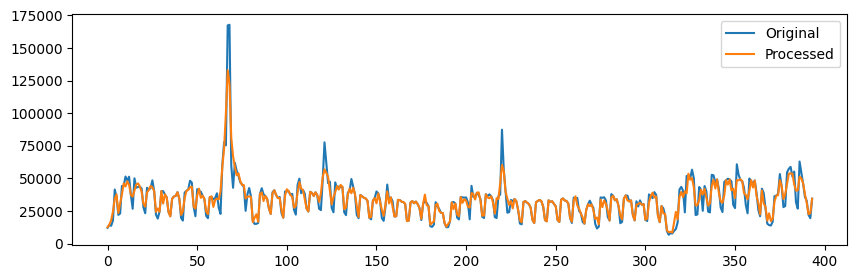

In [7]:
processed_signal = lstm.preprocess_smooth_signal_imfs(u, sigma=sigma, std_threshold=std_num)
original_signal = np.sum(u, axis=0)
# VMD 分解後會少最後一個值，因此要把原始資料的最後一個值去掉
original_data = data_source[:-1].reshape(-1)

print(original_data.shape)
print(processed_signal.shape) 
print(original_signal.shape)

mae = mean_absolute_error(original_data, processed_signal)
mape = mean_absolute_percentage_error(original_signal, processed_signal)

print(f'MAE: {mae:.4f}')
print(f'MAPE: {mape:.4f}')

plt.figure(figsize=(10, 3))
plt.plot(original_data, label='Original') 
plt.plot(processed_signal, label='Processed')
plt.legend()
plt.show() 

# EEMD 訊號分解

# 訊號分解
EEMD


IMFs shape : (8, 394)
eIMFs shape : (8, 394)
residue shape : (394,)


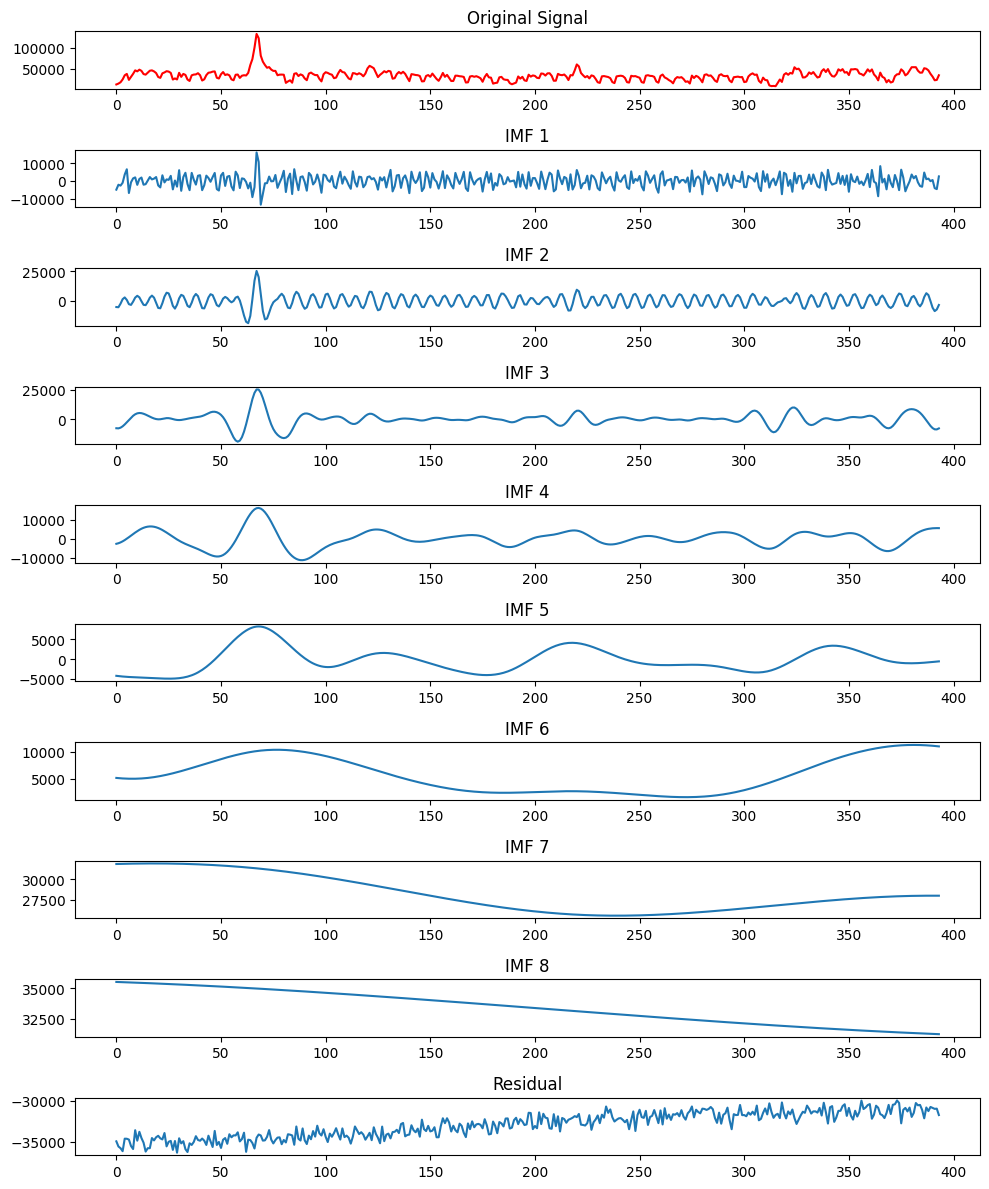

In [8]:
eIMFs, residue, imfs = lstm.decomposition(processed_signal, is_emd = is_emd)

# 刪除訊號分解後的訓練資料

In [9]:
def print_step(index):
    print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
    # 最後一個是殘差
    if index == len(imfs):
        print(f'\x1b[31m殘差\x1b[0m')
    else:
        print(f'\x1b[31m第 {index} 個 IMF\x1b[0m')
        print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
   

for i in range(len(imfs)):
    print_step(i + 1)

    lstm.del_file(x_scaler_file_name.replace('.pkl', f'.{i + 1}.pkl'))
    lstm.del_file(y_scaler_file_name.replace('.pkl', f'.{i + 1}.pkl'))
    lstm.del_file(model_file_name.replace('.keras', f'.{i + 1}.keras'))

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
------------------------------------------------------------------------
第 5 個 IMF
------------------------------------------------------------------------
------------------------------------------------------------------------
第 6 個 IMF
------------------------------------------------------------------------
----------------------------------------------------------------

# 最小最大正規化

In [10]:
x_norms = []
y_norms = []
x_scalers = []
y_scalers = []

for i in range(1, len(imfs) + 1):
    print_step(i) 
    x_norm, y_norm, x_scaler, y_scaler = \
        lstm.normalize_by_decomposition(imfs[i - 1]); 

    x_norms.append(x_norm)
    y_norms.append(y_norm)
    x_scalers.append(x_scaler)
    y_scalers.append(y_scaler)
 
    joblib.dump(x_scaler, x_scaler_file_name.replace('.pkl', f'.{i}.pkl'))
    joblib.dump(y_scaler, y_scaler_file_name.replace('.pkl', f'.{i}.pkl'))
    print('儲存最小最大縮放參數')
  

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 最小最大正規化
x_norm.shape:(394, 1)
y_norm.shape:(394, 1)
儲存最小最大縮放參數
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 最小最大正規化
x_norm.shape:(394, 1)
y_norm.shape:(394, 1)
儲存最小最大縮放參數
------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
# 最小最大正規化
x_norm.shape:(394, 1)
y_norm.shape:(394, 1)
儲存最小最大縮放參數
------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
# 最小最大正規化
x_norm.shape:(394, 1)
y_norm.shape:(394, 1)
儲存最小最大縮放參數
------------------------------------------------------------------------
第 5 個 IMF
---------------------------------

# 切割訓練、驗證和測試資料集

In [11]:
x_trains = []
y_trains = []

x_vals = []
y_vals = []

x_tests = []
y_tests = []

for i in range(len(x_norms)):
    print_step(i + 1)
    
    x_train, y_train, x_val, y_val, x_test, y_test = \
        lstm.train_val_test_split(
            x_norms[i],  
            train_split_rate = train_split_rate,
            val_split_rate = val_split_rate
        )

    x_trains.append(x_train)
    y_trains.append(y_train)

    x_vals.append(x_val)
    y_vals.append(y_val)

    x_tests.append(x_test)
    y_tests.append(y_test)
    

print('\n\x1b[31m------------------------------------------------------------------------\x1b[0m')
print('\x1b[31m已切割\x1b[0m')
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print(f'x_trains len : {len(x_trains)}')
print(f'y_trains len : {len(y_trains)}')
print(f'x_vals len : {len(x_vals)}')
print(f'y_vals len : {len(y_vals)}')
print(f'x_tests len : {len(x_tests)}')
print(f'y_tests len : {len(y_tests)}')


------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 切割訓練、驗證和測試資料集
x_train.shape: (315, 1)
y_train.shape: (315, 1)
x_val.shape: (39, 1)
y_val.shape: (39, 1)
x_test.shape: (40, 1)
y_test.shape: (40, 1)
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 切割訓練、驗證和測試資料集
x_train.shape: (315, 1)
y_train.shape: (315, 1)
x_val.shape: (39, 1)
y_val.shape: (39, 1)
x_test.shape: (40, 1)
y_test.shape: (40, 1)
------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
# 切割訓練、驗證和測試資料集
x_train.shape: (315, 1)
y_train.shape: (315, 1)
x_val.shape: (39, 1)
y_val.shape: (39, 1)
x_test.shape: (40, 1)
y_test.shape: (40, 1)
------------------------------------------------------------------------
第 4 個 IMF

# 將資料轉成 LSTM 模型所需資料格式(三維)

In [12]:
x_lstm_trains = []
y_lstm_trains = []

x_lstm_vals = []
y_lstm_vals = []

x_lstm_tests = []
y_lstm_tests = []

for i in range(len(x_trains)):
    print_step(i + 1)
    
    # 訓練集
    x_lstm_train, y_lstm_train, _ = \
        lstm.reshape_data_for_lstm(
            x_trains[i], y_trains[i],
            date_array = None,
            past_day = past_day,
            future_day = future_day
        ) 
    print('====== Train DataSet ======')
    print('訓練集 : x_k_lstm_train (筆數, 天數, 特徵數) :', x_lstm_train.shape)
    print('訓練集 : y_k_lstm_train (筆數, 天數, 標籤數) :', y_lstm_train.shape)

    # 驗證集
    x_lstm_val, y_lstm_val, _ = \
        lstm.reshape_data_for_lstm(
            x_vals[i], y_vals[i],
            date_array = None,
            past_day = past_day,
            future_day = future_day
        )
    print('====== Val DataSet ======')
    print('驗證集 : x_k_lstm_test (筆數, 天數, 特徵數) :', x_lstm_val.shape)
    print('驗證集 : y_k_lstm_test (筆數, 天數, 標籤數) :', y_lstm_val.shape)

    # 測試集
    x_lstm_test, y_lstm_test, _ = \
        lstm.reshape_data_for_lstm(
            x_tests[i], y_tests[i],
            date_array = None,
            past_day = past_day,
            future_day = future_day
        )
    print('====== Test DataSet ======')
    print('測試集 : x_lstm_test (筆數, 天數, 特徵數) :', x_lstm_test.shape)
    print('測試集 : y_lstm_test (筆數, 天數, 標籤數) :', y_lstm_test.shape)
     
    x_lstm_trains.append(x_lstm_train)
    y_lstm_trains.append(y_lstm_train)

    x_lstm_vals.append(x_lstm_val)
    y_lstm_vals.append(y_lstm_val)

    x_lstm_tests.append(x_lstm_test)
    y_lstm_tests.append(y_lstm_test)

print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print('\x1b[31m已轉換\x1b[0m')
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print(f'x_lstm_trains len : {len(x_lstm_trains)}')
print(f'y_lstm_trains len : {len(y_lstm_trains)}')
print(f'x_lstm_vals len : {len(x_lstm_vals)}')
print(f'y_lstm_vals len : {len(y_lstm_vals)}')
print(f'x_lstm_tests len : {len(x_lstm_tests)}')
print(f'y_lstm_tests len : {len(y_lstm_tests)}')

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
====== Train DataSet ======
訓練集 : x_k_lstm_train (筆數, 天數, 特徵數) : (300, 14, 1)
訓練集 : y_k_lstm_train (筆數, 天數, 標籤數) : (300, 1)
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
====== Val DataSet ======
驗證集 : x_k_lstm_test (筆數, 天數, 特徵數) : (24, 14, 1)
驗證集 : y_k_lstm_test (筆數, 天數, 標籤數) : (24, 1)
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
====== Test DataSet ======
測試集 : x_lstm_test (筆數, 天數, 特徵數) : (25, 14, 1)
測試集 : y_lstm_test (筆數, 天數, 標籤數) : (25, 1)
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
====== Train DataSet ======
訓練集 : x_k_lstm_train (筆數, 天數, 特徵數) : (300, 14, 1)
訓練集 : y_k_lstm_train (筆數, 天數, 標籤數) : (300, 1)
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
====== Val DataSet ======
驗

# 定義 Model

In [13]:
models = []

for i in range(len(x_trains)):
    print_step(i + 1)    
    
    # 定義 Model
    model = lstm.build_model(
        model_type = model_type,
        time_step = past_day,
        n_predictions = future_day
    )
    
    models.append(model)

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 定義 Model：1
LSTM


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 150)                 │          15,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 150)                 │          22,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 78,751 (307.62 KB)

 Trainable params: 78,751 (307.62 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 定義 Model：1
LSTM


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 150)                 │          15,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 150)                 │          22,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 78,751 (307.62 KB)

 Trainable params: 78,751 (307.62 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
# 定義 Model：1
LSTM


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 150)                 │          15,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 150)                 │          22,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 78,751 (307.62 KB)

 Trainable params: 78,751 (307.62 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
# 定義 Model：1
LSTM


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 150)                 │          15,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 150)                 │          22,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 78,751 (307.62 KB)

 Trainable params: 78,751 (307.62 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
第 5 個 IMF
------------------------------------------------------------------------
# 定義 Model：1
LSTM


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 150)                 │          15,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 150)                 │          22,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 78,751 (307.62 KB)

 Trainable params: 78,751 (307.62 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
第 6 個 IMF
------------------------------------------------------------------------
# 定義 Model：1
LSTM


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                        │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 150)                 │          15,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 150)                 │          22,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 78,751 (307.62 KB)

 Trainable params: 78,751 (307.62 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
第 7 個 IMF
------------------------------------------------------------------------
# 定義 Model：1
LSTM


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 150)                 │          15,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 150)                 │          22,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 78,751 (307.62 KB)

 Trainable params: 78,751 (307.62 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
第 8 個 IMF
------------------------------------------------------------------------
# 定義 Model：1
LSTM


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                        │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 150)                 │          15,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 150)                 │          22,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 78,751 (307.62 KB)

 Trainable params: 78,751 (307.62 KB)

 Non-trainable params: 0 (0.00 B)

------------------------------------------------------------------------
殘差
# 定義 Model：1
LSTM


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 100)                 │          40,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 150)                 │          15,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 150)                 │          22,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 1)                   │             151 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 78,751 (307.62 KB)

 Trainable params: 78,751 (307.62 KB)

 Non-trainable params: 0 (0.00 B)

# 訓練

In [14]:
train_historys = []

for i in range(len(models)):
    print_step(i + 1) 
        
    train_history = lstm.model_fit(
        model = models[i],
        batch_size = batch_size,
        x_train = x_lstm_trains[i],
        y_train = y_lstm_trains[i],
        x_val = x_lstm_vals[i],
        y_val = y_lstm_vals[i],
    ) 
    
    train_historys.append(train_history) 

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
第 5 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
第 6 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
第 7 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
第 8 個 IMF
------------------------------------------------------------------------
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


------------------------------------------------------------------------
殘差
# 訓練 Model
EarlyStopping => mointor: val_loss，patience: 50


# 儲存模型

In [15]:
for i in range(len(models)):
    print_step(i + 1)  
    
    file_name = f'{model_file_name.replace(".keras", f".{i + 1}.keras")}'
    models[i].save(file_name)
    print(f'儲存模型到 {file_name}')

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
儲存模型到 VMD_DecompEEMD/_Model/GroupCount_mt1_data3_batch14.model.1.keras
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
儲存模型到 VMD_DecompEEMD/_Model/GroupCount_mt1_data3_batch14.model.2.keras
------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
儲存模型到 VMD_DecompEEMD/_Model/GroupCount_mt1_data3_batch14.model.3.keras
------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
儲存模型到 VMD_DecompEEMD/_Model/GroupCount_mt1_data3_batch14.model.4.keras
------------------------------------------------------------------------
第 5 個 IMF
---------

# 預測

In [16]:
predict_trains = []
predict_vals = []
predict_tests = []

for i in range(len(models)):
    print_step(i + 1)    
  
    predict_train = lstm.predict(models[i], x_lstm_trains[i])
    print(f'預測 train.shape : {predict_train.shape}')

    predict_val = lstm.predict(models[i], x_lstm_vals[i])
    print(f'預測 val.shape : {predict_val.shape}')

    predict_test = lstm.predict(models[i], x_lstm_tests[i])
    print(f'預測 test.shape : {predict_test.shape}') 
    
    predict_trains.append(predict_train)
    predict_vals.append(predict_val)
    predict_tests.append(predict_test)

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 預測
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (300, 1)
預測 train.shape : (300, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (300, 1)
預測 train.shape : (300, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (300, 1)
預測 train.shape : (300, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (300, 1)
預測 train.shape : (300, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
第 5 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (300, 1)
預測 train.shape : (300, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
第 6 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (300, 1)
預測 train.shape : (300, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
第 7 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (300, 1)
預測 train.shape : (300, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
第 8 個 IMF
------------------------------------------------------------------------
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (300, 1)
預測 train.shape : (300, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)
------------------------------------------------------------------------
殘差
# 預測


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


預測 shape : (300, 1)
預測 train.shape : (300, 1)
# 預測
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (24, 1)
預測 val.shape : (24, 1)
# 預測


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


預測 shape : (25, 1)
預測 test.shape : (25, 1)


# 回復預測資料值為原始數據的規模

In [17]:
predict_inverse_trains = []
predict_inverse_vals = []
predict_inverse_tests = []

actual_inverse_trains = []
actual_inverse_vals = []
actual_inverse_tests = []

actual_trains = []
actual_vals = []
actual_tests = []


for i in range(len(models)):
    print_step(i + 1)
    
    # 訓練
    predict_inverse_train, actual_inverse_train, predict_train, actual_train = \
        lstm.denormalize_and_reshape_back(
            y_predict = predict_trains[i],
            y_lstm_actual = y_lstm_trains[i],
            y_scaler = y_scalers[i],
            n_predictions = future_day
        )
    print(f'predict_inverse_train.shape : {predict_inverse_train.shape}') 
    print(f'actual_inverse_train.shape : {actual_inverse_train.shape}')

    # 驗證
    predict_inverse_val, actual_inverse_val, predict_val, actual_val = \
        lstm.denormalize_and_reshape_back(
            y_predict = predict_vals[i],
            y_lstm_actual = y_lstm_vals[i],
            y_scaler = y_scalers[i],
            n_predictions = future_day
        )
    print(f'predict_inverse_val.shape : {predict_inverse_val.shape}')
    print(f'actual_inverse_val.shape : {actual_inverse_val.shape}')
    
    # 測試
    predict_inverse_test, actual_inverse_test, predict_test, actual_test = \
        lstm.denormalize_and_reshape_back(
            y_predict = predict_tests[i],
            y_lstm_actual = y_lstm_tests[i],
            y_scaler = y_scalers[i],
            n_predictions = future_day
        )
    print(f'predict_inverse_test.shape : {predict_inverse_test.shape}')
    print(f'actual_inverse_test.shape : {actual_inverse_test.shape}')

    predict_inverse_trains.append(predict_inverse_train)
    predict_inverse_vals.append(predict_inverse_val)
    predict_inverse_tests.append(predict_inverse_test)

    actual_inverse_trains.append(actual_inverse_train)
    actual_inverse_vals.append(actual_inverse_val)
    actual_inverse_tests.append(actual_inverse_test)

    actual_trains.append(actual_train)
    actual_vals.append(actual_val)
    actual_tests.append(actual_test)
    

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 回復預測資料值為原始數據的規模
predict_inverse_train.shape : (300, 1)
actual_inverse_train.shape : (300, 1)
# 回復預測資料值為原始數據的規模
predict_inverse_val.shape : (24, 1)
actual_inverse_val.shape : (24, 1)
# 回復預測資料值為原始數據的規模
predict_inverse_test.shape : (25, 1)
actual_inverse_test.shape : (25, 1)
------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 回復預測資料值為原始數據的規模
predict_inverse_train.shape : (300, 1)
actual_inverse_train.shape : (300, 1)
# 回復預測資料值為原始數據的規模
predict_inverse_val.shape : (24, 1)
actual_inverse_val.shape : (24, 1)
# 回復預測資料值為原始數據的規模
predict_inverse_test.shape : (25, 1)
actual_inverse_test.shape : (25, 1)
------------------------------------------------------------------------
第 3 個 IMF
-------------------------------------------------------

# 預測資料加總

In [18]:
# 根據原始數據進行切割
x_train_origin, y_train_origin , x_val_origin, y_val_origin, x_test_origin, y_test_origin = \
    lstm.train_val_test_split(processed_signal, train_split_rate, val_split_rate)

# 使用原始數據進行 LSTM 模型所需的格式資料轉換
# 主要是為了後面的驗證圖表
y_lstm_origin_train, y_lstm_origin_train, _ = lstm.reshape_data_for_lstm(
    x_train_origin, y_train_origin,
    date_array = None,
    past_day = past_day,
    future_day = future_day
)
y_lstm_origin_train = y_lstm_origin_train.reshape(
    y_lstm_origin_train.shape[0], 
    y_lstm_origin_train.shape[1]
)

print(f'x_lstm_origin_train.shape : {y_lstm_origin_train.shape}')
print(f'y_lstm_origin_train.shape : {y_lstm_origin_train.shape}')

x_lstm_origin_test, y_lstm_origin_test, _ = lstm.reshape_data_for_lstm(
    x_test_origin, y_test_origin,
    date_array = None,
    past_day = past_day,
    future_day = future_day
)
y_lstm_origin_test = y_lstm_origin_test.reshape(
    y_lstm_origin_test.shape[0], 
    y_lstm_origin_test.shape[1]
)

print(f'x_lstm_origin_test.shape : {x_lstm_origin_test.shape}')
print(f'y_lstm_origin_test.shape : {y_lstm_origin_test.shape}')

x_lstm_origin_val, y_lstm_origin_val, _ = lstm.reshape_data_for_lstm(
    x_val_origin, y_val_origin,
    date_array = None,
    past_day = past_day,
    future_day = future_day
)
y_lstm_origin_val = y_lstm_origin_val.reshape(
    y_lstm_origin_val.shape[0], 
    y_lstm_origin_val.shape[1]
)

print(f'x_lstm_origin_val.shape : {x_lstm_origin_val.shape}')
print(f'y_lstm_origin_val.shape : {y_lstm_origin_val.shape}')

# 切割訓練、驗證和測試資料集
x_train.shape: (315,)
y_train.shape: (315,)
x_val.shape: (39,)
y_val.shape: (39,)
x_test.shape: (40,)
y_test.shape: (40,)
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
x_lstm_origin_train.shape : (300, 1)
y_lstm_origin_train.shape : (300, 1)
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
x_lstm_origin_test.shape : (25, 14)
y_lstm_origin_test.shape : (25, 1)
# 將資料轉成 LSTM 模型所需資料格式，LSTM 的輸入必須是三維
x_lstm_origin_val.shape : (24, 14)
y_lstm_origin_val.shape : (24, 1)


In [19]:
predict_inverse_train_sum = np.sum(predict_inverse_trains, axis=0)
actual_inverse_train_sum = np.sum(actual_inverse_trains, axis=0)

predict_inverse_val_sum = np.sum(predict_inverse_vals, axis=0)
actual_inverse_val_sum = np.sum(actual_inverse_vals, axis=0)

predict_inverse_test_sum = np.sum(predict_inverse_tests, axis=0)
actual_inverse_test_sum = np.sum(actual_inverse_tests, axis=0)

print('predict_inverse_train_sum', predict_inverse_train_sum.shape)
print('actual_inverse_train_sum', actual_inverse_train_sum.shape)

print('predict_inverse_val_sum', predict_inverse_val_sum.shape)
print('actual_inverse_val_sum', actual_inverse_val_sum.shape)

print('predict_inverse_test_sum', predict_inverse_test_sum.shape)
print('actual_inverse_test_sum', actual_inverse_test_sum.shape)

predict_inverse_train_sum (300, 1)
actual_inverse_train_sum (300, 1)
predict_inverse_val_sum (24, 1)
actual_inverse_val_sum (24, 1)
predict_inverse_test_sum (25, 1)
actual_inverse_test_sum (25, 1)


# 查看訓練 & 驗證 & 測試集評估數據

In [20]:
for i in range(len(models)):
    print_step(i + 1)
    print('\033[93m# 查看訓練 & 驗證 & 測試集評估數據\x1b[0m')

    print('====== Train Evaluate ======')
    lstm.evaluation(models[i], x_lstm_trains[i], y_lstm_trains[i])
    print('--- 訓練值比較 --- ')
    lstm.score(actual_trains[i], predict_trains[i])
    print('--- 原始值比較 --- ')
    lstm.score(actual_inverse_trains[i], predict_inverse_trains[i])
    print('')

    print('====== Val Evaluate ======')
    lstm.evaluation(models[i], x_lstm_vals[i], y_lstm_vals[i])
    print('--- 正規化比較 --- ')
    lstm.score(actual_vals[i], predict_vals[i])
    print('--- 原始值比較 --- ')
    lstm.score(actual_inverse_vals[i], predict_inverse_vals[i])
    print('')

    print('====== Test Evaluate ======')
    lstm.evaluation(models[i], x_lstm_tests[i], y_lstm_tests[i])
    print('--- 正規化比較 --- ')
    lstm.score(actual_tests[i], predict_tests[i])
    print('--- 原始值比較 --- ')
    lstm.score(actual_inverse_tests[i], predict_inverse_tests[i])
    print('')
    
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print('\x1b[31m合併後 Train Evaluate\x1b[0m')
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
mae_train, mape_train = lstm.score(y_lstm_origin_train, predict_inverse_train_sum)
print('')

print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print('\x1b[31m合併後 Val Evaluate\x1b[0m')
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
mae_val, mape_val = lstm.score(y_lstm_origin_val, predict_inverse_val_sum)
print('')

print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
print('\x1b[31m合併後 Test Evaluate\x1b[0m')
print('\x1b[31m------------------------------------------------------------------------\x1b[0m')
mae_test, mape_test = lstm.score(y_lstm_origin_test, predict_inverse_test_sum)
print('')

------------------------------------------------------------------------
第 1 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0132 - mean_absolute_percentage_error: 21.2784

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0151 - mean_absolute_percentage_error: 929592.2500


--- 訓練值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:0.09955，MAPE:2405155960695.69，MSE:0.01451，RMSE:0.12045，R square:0.07363
--- 原始值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:2928.15482，MAPE:1.91199，MSE:12550531.18064，RMSE:3542.67289，R square:0.07363

====== Val Evaluate ======
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0176 - mean_absolute_percentage_error: 22.0407

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0176 - mean_absolute_percentage_error: 22.0407


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.10455，MAPE:0.22041，MSE:0.01764，RMSE:0.13282，R square:-0.45511
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:3075.11486，MAPE:2.68606，MSE:15262727.31549，RMSE:3906.75406，R square:-0.45511

====== Test Evaluate ======
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0114 - mean_absolute_percentage_error: 18.4349

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0114 - mean_absolute_percentage_error: 18.4349


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.08611，MAPE:0.18435，MSE:0.0114，RMSE:0.10679，R square:0.05085
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:2532.80837，MAPE:1.66841，MSE:9865728.31884，RMSE:3140.9757，R square:0.05085

------------------------------------------------------------------------
第 2 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.1014e-04 - mean_absolute_percentage_error: 4.8441

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0020 - mean_absolute_percentage_error: 1681955.6250


--- 訓練值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:0.02464，MAPE:4351837136923.401，MSE:0.00148，RMSE:0.03846，R square:0.88915
--- 原始值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:1086.31307，MAPE:3.15845，MSE:2875599.26734，RMSE:1695.7592，R square:0.88915

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.2511e-04 - mean_absolute_percentage_error: 3.3011

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.2511e-04 - mean_absolute_percentage_error: 3.3011


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.01429，MAPE:0.03301，MSE:0.00033，RMSE:0.01803，R square:0.96201
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:630.27925，MAPE:0.60784，MSE:632103.00003，RMSE:795.04906，R square:0.96201

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0012 - mean_absolute_percentage_error: 7.7215

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0012 - mean_absolute_percentage_error: 7.7215


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.02612，MAPE:0.07722，MSE:0.00118，RMSE:0.03438，R square:0.88356
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:1151.54774，MAPE:0.4163，MSE:2297952.31806，RMSE:1515.89984，R square:0.88356

------------------------------------------------------------------------
第 3 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2882e-04 - mean_absolute_percentage_error: 2.0892

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7757e-04 - mean_absolute_percentage_error: 1534.6261


--- 訓練值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:0.00866，MAPE:3960548447.60359，MSE:0.00014，RMSE:0.01173，R square:0.99067
--- 原始值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:388.43793，MAPE:1.53554，MSE:277106.67069，RMSE:526.40922，R square:0.99067

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.9047e-05 - mean_absolute_percentage_error: 1.6800

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.9047e-05 - mean_absolute_percentage_error: 1.6800


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.00651，MAPE:0.0168，MSE:7e-05，RMSE:0.00831，R square:0.96825
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:292.25063，MAPE:0.42641，MSE:139008.13573，RMSE:372.83795，R square:0.96825

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3779e-04 - mean_absolute_percentage_error: 2.2803

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3779e-04 - mean_absolute_percentage_error: 2.2803


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.00946，MAPE:0.0228，MSE:0.00014，RMSE:0.01174，R square:0.99312
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:424.61857，MAPE:0.10584，MSE:277394.38672，RMSE:526.68243，R square:0.99312

------------------------------------------------------------------------
第 4 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.2960e-05 - mean_absolute_percentage_error: 2.0685

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.3750e-05 - mean_absolute_percentage_error: 47232.5352


--- 訓練值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:0.00749，MAPE:161779771856.32318，MSE:7e-05，RMSE:0.00861，R square:0.99755
--- 原始值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:206.25494，MAPE:0.67991，MSE:56146.51249，RMSE:236.95255，R square:0.99755

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1430e-04 - mean_absolute_percentage_error: 2.0008

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1430e-04 - mean_absolute_percentage_error: 2.0008


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.00959，MAPE:0.02001，MSE:0.00011，RMSE:0.01069，R square:0.84515
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:263.92691，MAPE:0.15954，MSE:86615.97578，RMSE:294.30592，R square:0.84515

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.1009e-05 - mean_absolute_percentage_error: 2.0634

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.1009e-05 - mean_absolute_percentage_error: 2.0634


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.00678，MAPE:0.02063，MSE:6e-05，RMSE:0.00781，R square:0.99757
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:186.75439，MAPE:0.05724，MSE:46230.87998，RMSE:215.01367，R square:0.99757

------------------------------------------------------------------------
第 5 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.6966e-05 - mean_absolute_percentage_error: 226052.5938

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.6045e-05 - mean_absolute_percentage_error: 62521.4492 


--- 訓練值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:0.00649，MAPE:108473523459.69617，MSE:5e-05，RMSE:0.00714，R square:0.99913
--- 原始值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:86.03156，MAPE:0.09644，MSE:8953.10977，RMSE:94.62087，R square:0.99913

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.2356e-05 - mean_absolute_percentage_error: 1.3142

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.2356e-05 - mean_absolute_percentage_error: 1.3142


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.00771，MAPE:0.01314，MSE:6e-05，RMSE:0.0079，R square:0.95967
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:102.07846，MAPE:0.03741，MSE:10941.50197，RMSE:104.60163，R square:0.95967

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.8103e-05 - mean_absolute_percentage_error: 1.9408

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.8103e-05 - mean_absolute_percentage_error: 1.9408


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.00598，MAPE:0.01941，MSE:4e-05，RMSE:0.00617，R square:0.77311
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:79.18583，MAPE:0.09628，MSE:6685.82592，RMSE:81.7669，R square:0.77311

------------------------------------------------------------------------
第 6 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0952e-05 - mean_absolute_percentage_error: 0.6257

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.3245e-06 - mean_absolute_percentage_error: 3879.8730


--- 訓練值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:0.00255，MAPE:63027023271.58242，MSE:1e-05，RMSE:0.00295，R square:0.99991
--- 原始值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:24.95264，MAPE:0.00801，MSE:830.31182，RMSE:28.81513，R square:0.99991

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.9210e-05 - mean_absolute_percentage_error: 0.6390

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9210e-05 - mean_absolute_percentage_error: 0.6390


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.00434，MAPE:0.00639，MSE:2e-05，RMSE:0.00438，R square:0.99778
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:42.36033，MAPE:0.00517，MSE:1832.89538，RMSE:42.81233，R square:0.99778

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.6531e-06 - mean_absolute_percentage_error: 0.2340

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.6531e-06 - mean_absolute_percentage_error: 0.2340


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.00232，MAPE:0.00234，MSE:1e-05，RMSE:0.00238，R square:0.93258
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:22.63655，MAPE:0.00202，MSE:539.40205，RMSE:23.22503，R square:0.93258

------------------------------------------------------------------------
第 7 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.5527e-07 - mean_absolute_percentage_error: 0.0475

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.1400e-07 - mean_absolute_percentage_error: 1392.9635


--- 訓練值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:0.00062，MAPE:16250795895.70436，MSE:0.0，RMSE:0.00074，R square:1.0
--- 原始值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:4.01846，MAPE:0.00015，MSE:22.82475，RMSE:4.77753，R square:1.0

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.0748e-06 - mean_absolute_percentage_error: 0.8477

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.0748e-06 - mean_absolute_percentage_error: 0.8477


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.00246，MAPE:0.00848，MSE:1e-05，RMSE:0.00246，R square:0.98832
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:15.95918，MAPE:0.00058，MSE:254.93863，RMSE:15.9668，R square:0.98832

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.5517e-06 - mean_absolute_percentage_error: 0.4971

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.5517e-06 - mean_absolute_percentage_error: 0.4971


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.00187，MAPE:0.00497，MSE:0.0，RMSE:0.00188，R square:0.89109
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:12.12183，MAPE:0.00043，MSE:149.04665，RMSE:12.20847，R square:0.8911

------------------------------------------------------------------------
第 8 個 IMF
------------------------------------------------------------------------
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6436e-07 - mean_absolute_percentage_error: 0.0368

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.3832e-07 - mean_absolute_percentage_error: 0.0972


--- 訓練值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:0.00061，MAPE:0.00105，MSE:0.0，RMSE:0.00077，R square:0.99999
--- 原始值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:2.60864，MAPE:8e-05，MSE:10.65986，RMSE:3.26494，R square:0.99999

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.8818e-06 - mean_absolute_percentage_error: 1.7211

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.8818e-06 - mean_absolute_percentage_error: 1.7211


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.00168，MAPE:0.01721，MSE:0.0，RMSE:0.0017，R square:0.98865
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:7.18132，MAPE:0.00023，MSE:52.44753，RMSE:7.24207，R square:0.98865

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.8384e-06 - mean_absolute_percentage_error: 121252.7266

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.8384e-06 - mean_absolute_percentage_error: 121252.7266


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.0028，MAPE:545955103375.62354，MSE:1e-05，RMSE:0.0028，R square:0.95357
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:11.92492，MAPE:0.00038，MSE:142.65037，RMSE:11.94363，R square:0.95357

------------------------------------------------------------------------
殘差
# 查看訓練 & 驗證 & 測試集評估數據
====== Train Evaluate ======


 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0097 - mean_absolute_percentage_error: 5289142.5000

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0108 - mean_absolute_percentage_error: 1462858.0000


--- 訓練值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:0.08691，MAPE:2540774250687.466，MSE:0.0114，RMSE:0.10678，R square:0.75193
--- 原始值比較 --- 
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:551.44748，MAPE:0.0167，MSE:459012.79842，RMSE:677.50483，R square:0.75193

====== Val Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0143 - mean_absolute_percentage_error: 13.3413

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0143 - mean_absolute_percentage_error: 13.3413


--- 正規化比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:0.10387，MAPE:0.13341，MSE:0.01432，RMSE:0.11968，R square:-0.36653
--- 原始值比較 --- 
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:659.02451，MAPE:0.02111，MSE:576621.58651，RMSE:759.35603，R square:-0.36653

====== Test Evaluate ======


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0145 - mean_absolute_percentage_error: 12.3017

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0145 - mean_absolute_percentage_error: 12.3017


--- 正規化比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:0.10168，MAPE:0.12302，MSE:0.01454，RMSE:0.12057，R square:-0.44181
--- 原始值比較 --- 
Actual shape: (25, 1), Predict shape: (25, 1)
MAE:645.12564，MAPE:0.02088，MSE:585216.7863，RMSE:764.99463，R square:-0.44181

------------------------------------------------------------------------
合併後 Train Evaluate
------------------------------------------------------------------------
Actual shape: (300, 1), Predict shape: (300, 1)
MAE:3339.54844，MAPE:0.10848，MSE:17619793.99642，RMSE:4197.59383，R square:0.89929

------------------------------------------------------------------------
合併後 Val Evaluate
------------------------------------------------------------------------
Actual shape: (24, 1), Predict shape: (24, 1)
MAE:3224.92725，MAPE:0.07573，MSE:16347925.74455，RMSE:4043.25682，R square:0.62428

------------------------------------------------------------------------
合併後 Test Evaluate
----------------------------------------------------------

# 顯示原始數據圖表

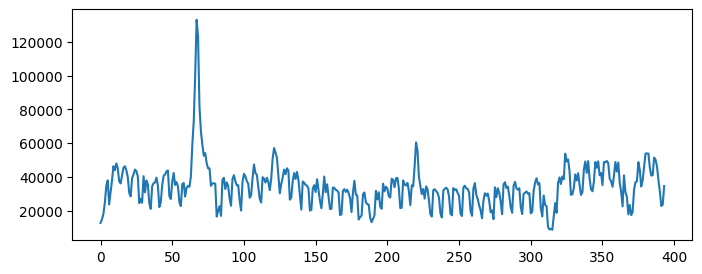

In [21]:
plt.figure(figsize=(8, 3))
plt.plot(processed_signal)
plt.show()

## 訓練集

原始資料 (315,)
[10348.88045241  8771.26358468  9148.69764905]
原始資料2 (300, 1)
[[10348.88045241]
 [ 8771.26358468]
 [ 9148.69764905]]
還原原始資料 (300, 1)
[[-31351.14129632]
 [-32082.52840861]]


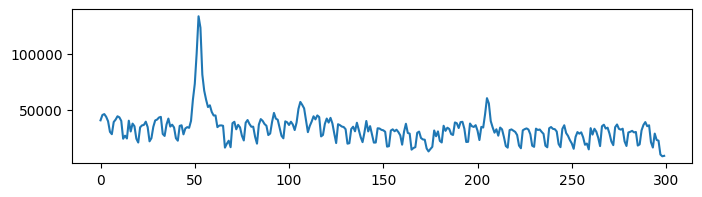

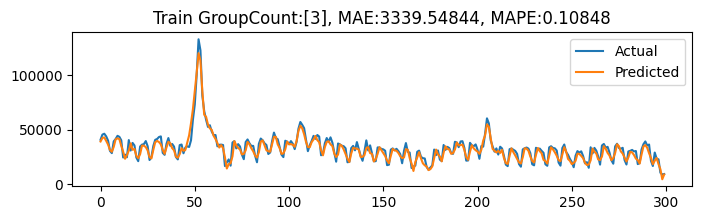

In [22]:
print('原始資料' , y_train_origin.shape)
print(y_train_origin[-3:])

print('原始資料2', y_lstm_origin_train.shape)
print(y_lstm_origin_train[-3:])

print('還原原始資料', actual_inverse_train.shape)
print(actual_inverse_train[-2:])

lstm.show_predict_chart(
    actual = y_lstm_origin_train,
    predict = predict_inverse_train_sum,
    title = f'Train {labels[0]}:{predicteds}, MAE:{round(mae_train, 5)}, MAPE:{round(mape_train, 5)}'
)

## 驗證集

原始資料 (39,)
[48732.7574086  48587.23205101 49388.82035301]
原始資料2 (24, 1)
[[48732.7574086 ]
 [48587.23205101]
 [49388.82035301]]
還原原始資料 (24, 1)
[[-32299.72479482]
 [-31223.17421163]]


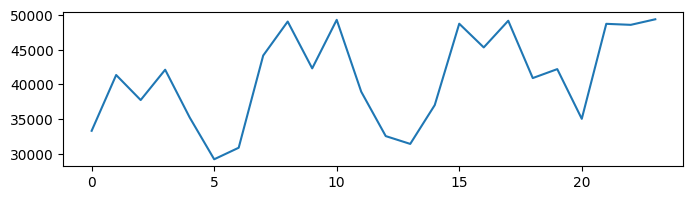

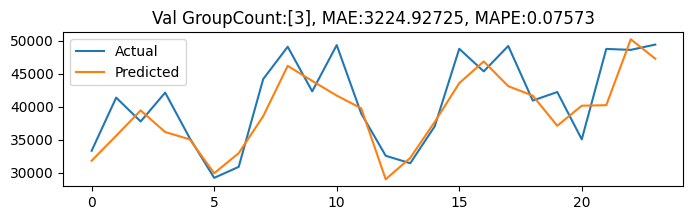

In [23]:
print('原始資料' , y_val_origin.shape)
print(y_val_origin[-3:])

print('原始資料2', y_lstm_origin_val.shape)
print(y_lstm_origin_val[-3:])

print('還原原始資料', actual_inverse_val.shape)
print(actual_inverse_val[-2:])

lstm.show_predict_chart(
    actual = y_lstm_origin_val,
    predict = predict_inverse_val_sum,
    title = f'Val {labels[0]}:{predicteds}, MAE:{round(mae_val, 5)}, MAPE:{round(mape_val, 5)}'
)

## 測試集

原始資料 (40,)
[22673.2490746  23460.42952962 34530.44883716]
原始資料2 (25, 1)
[[22673.2490746 ]
 [23460.42952962]
 [34530.44883716]]
還原原始資料 (25, 1)
[[-30966.72803092]
 [-31744.70032408]]
Test GroupCount:[3], BatchSize:14, MAE:2990.93445, MAPE:0.08932


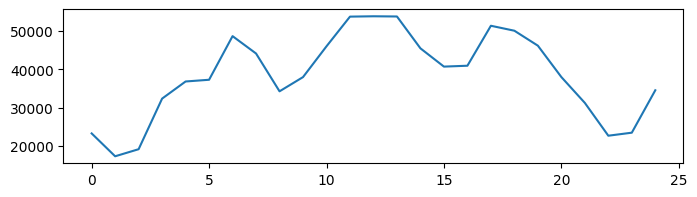

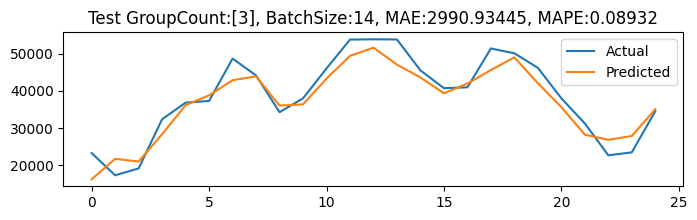

In [24]:
print('原始資料' , y_test_origin.shape)
print(y_test_origin[-3:])

print('原始資料2', y_lstm_origin_test.shape)
print(y_lstm_origin_test[-3:])

print('還原原始資料', actual_inverse_test.shape)
print(actual_inverse_test[-2:]) 

title = f'Test {labels[0]}:{predicteds}, BatchSize:{batch_size}, MAE:{round(mae_test, 5)}, MAPE:{round(mape_test, 5)}'
print(title)

lstm.show_predict_chart(
    actual = y_lstm_origin_test,
    predict = predict_inverse_test_sum,
    title = title
)

# 儲存結果

In [25]:
lstm.save_json_file(
    result_file_name, model_dir, labels, model_type, predicteds, 
    batch_size, mae_train, mape_train, mae_test, mape_test,
    imfs = len(imfs)
)

{'type': 'VMD_DecompEEMD', 'labels': ['GroupCount'], 'model_type': 1, 'predicteds': [3], 'batch_size': 14, 'train_mae': 3339.54844, 'train_mape': 0.10848, 'test_mae': 2990.93445, 'test_mape': 0.08932, 'kfold': None, 'imfs': 9}
儲存評估結果到 VMD_DecompEEMD/_Model/GroupCount_mt1_data3_batch14.result.json
